In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# from sklearn.model_selection import train_test_split
import numpy as np

!pip install -U aeon
# from aeon.datasets import load_classification, load_arrow_head
from aeon.classification.deep_learning  import CNNClassifier, MLPClassifier, TapNetClassifier, FCNClassifier
# from torchvision.ops import MLP
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

!pip install -U pyts
from pyts.image import GramianAngularField

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.5 MB/s eta 0:00:00


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/IA321/data"

Mounted at /content/drive


## Utils

In [4]:
def load_dataset(PATH,dataset):
  loaded_data = np.load(PATH + dataset)
  X_train = loaded_data['X_train']
  X_test = loaded_data['X_test']
  y_train = loaded_data['y_train']
  y_test = loaded_data['y_test']
  indices = loaded_data['indices']
  X_train_deq = X_train[indices]
  y_train_deq = y_train[indices]

  return X_train, X_test, X_train_deq, y_train, y_test, y_train_deq

In [5]:
def ohe_y(y):
  y_ohe = []
  for el in y :
    if el == 0 :
      y_ohe.append([1,0])
    else :
      y_ohe.append([0,1])
  return y_ohe

In [6]:
def normalize(X):
  a=-1
  b=1
  X_normalized = []
  for el in X :
    max = np.max(el)
    min = np.min(el)
    X_normalized.append((el - min) / (max - min) * (b - a) + a)
  return X_normalized


In [7]:
def transform_to_img(X_normalized):
  image_size = 1.0
  sample_range = (-1, 1)
  method = 'summation'  # Other options: 'difference', 'product', 'double_summation'

  gaf = GramianAngularField(image_size=image_size, sample_range=sample_range, method=method)

  gaf_images_X = gaf.fit_transform(X_normalized)

  gaf_images_X = np.array(gaf_images_X)
  return gaf_images_X


def create_dataset_and_loader_img(gaf_images_X,y_ohe,mlp=False):
  gaf_images_X_tensor = torch.tensor(gaf_images_X, dtype=torch.float32)
  if mlp:
    gaf_images_X_tensor = gaf_images_X_tensor.view(gaf_images_X_tensor.shape[0],1,-1)
  else:
    gaf_images_X_tensor = gaf_images_X_tensor.unsqueeze(1)
  y_tensor = torch.tensor(y_ohe, dtype=torch.float32)
  train_dataset = TensorDataset(gaf_images_X_tensor, y_tensor)
  batch_size = 32
  return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



def arrays_to_tensors(*arrays):
    return [torch.FloatTensor(arr) for arr in arrays]



def create_dataset_and_loader(X, y, batch_size, shuffle=True):
    X_tensor, y_tensor = arrays_to_tensors(X, y)

    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return loader


In [33]:
def train(model,num_epoch,criterion,dataloader,test_loader,optimizer):
  progress_bar = tqdm(range(num_epoch))
  losses=[]
  accuracies=[]
  best_accuracy=0


  for epoch in progress_bar :
      model.train()
      epoch_loss = 0.0
      n = 0
      for inputs, labels in dataloader:
          inputs, labels = inputs.to(device), labels.to(device)


          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          # _,labels_indices = torch.max(labels, 1)
          # loss = loss * class_weights[labels_indices]
          # loss = torch.mean(loss)
          # print("\n class weights:",class_weights)
          # print("\nloss:",loss)
          # print(outputs.shape)
          # print(labels)

          loss.backward()
          optimizer.step()
          epoch_loss += loss.item() * inputs.size(0)
          n+=1

      model.eval()
      total_correct = 0
      total_samples = 0
      with torch.no_grad():
          for test_inputs, test_labels in test_loader:
              test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
              outputs = model(test_inputs)
              # print(outputs)
              # print(labels)
              _, predicted = torch.max(outputs, 1)
              _,true_class = torch.max(test_labels,1)
              # print(predicted)
              # print(true_class)

              total_samples += test_labels.size(0)
              total_correct += (predicted == true_class).sum().item()

      accuracies.append(total_correct/total_samples)
      epoch_loss /= n
      progress_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
      losses.append(epoch_loss)

  return accuracies,losses



def plot_results(accuracies,losses):
    plt.plot(losses)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(accuracies)
    # plt.title("accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
    print("accuracy:", accuracies[-1])

In [9]:
# from sklearn.metrics import f1_score
# from tqdm import tqdm

# def train_model(model, num_epochs, criterion, dataloader, test_loader, optimizer, patience=5):
#     progress_bar = tqdm(range(num_epochs))
#     losses = []
#     accuracies = []
#     best_accuracy = 0
#     best_f1 = -1
#     epochs_no_improve = 0

#     for epoch in progress_bar:
#         model.train()
#         epoch_loss = 0.0
#         n = 0
#         all_predictions = []
#         all_true_labels = []

#         for inputs, labels in dataloader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item() * inputs.size(0)
#             n += 1

#         model.eval()
#         total_correct = 0
#         total_samples = 0
#         with torch.no_grad():
#             for test_inputs, test_labels in test_loader:
#                 test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
#                 outputs = model(test_inputs)
#                 _, predicted = torch.max(outputs, 1)
#                 _, true_class = torch.max(test_labels, 1)

#                 all_predictions.extend(predicted.cpu().numpy())
#                 all_true_labels.extend(true_class.cpu().numpy())

#                 total_samples += test_labels.size(0)
#                 total_correct += (predicted == true_class).sum().item()

#         current_f1 = f1_score(all_true_labels, all_predictions, average='weighted')
#         accuracies.append(total_correct / total_samples)
#         epoch_loss /= n
#         progress_bar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, F1: {current_f1:.4f}')

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             epochs_no_improve = 0
#             # Save the best model if needed
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve == patience:
#             print("Early stopping triggered")
#             break

#         losses.append(epoch_loss)

#     return accuracies, losses


In [10]:
def grid_search_parameter_tuning(model_class, param_grid, train_loader, test_loader, device):
    best_accuracy = 0.0
    best_params = None

    grid = ParameterGrid(param_grid)

    for params in grid:
        print(f"Testing parameters: {params}")
        model = model_class(**params)
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.CrossEntropyLoss(params['class_weights'])


        accuracies,losses = train(model,params['num_epochs'],criterion,train_loader,test_loader,optimizer)
        accuracy=accuracies[-1]
        print("accuracy:",accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params

    return best_accuracy, best_params

In [11]:

def evaluate_model(model, test_loader, device):
    """
    Evaluates a trained model on a test_loader, plots the confusion matrix,
    and prints accuracy by class.

    Parameters:
    - model: Trained model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - device: The device (CPU or CUDA) on which the model and data are located.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    all_predictions = []
    all_labels = []

    # No gradient is needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            _, true_class = torch.max(labels, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(true_class.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate and print accuracy per class
    print("Accuracy by class:")
    for i in range(cm.shape[0]):
        acc = cm[i, i] / np.sum(cm[i])
        print(f"Class {i}: {acc * 100:.2f}%")

# Traitement des données

## Chargement des données

Le jeu de données est constitué de séries temporelles représentant  la composante verticale d'un mouvement de main. Il y a deux classes représentant deux types de mouvements: Un mouvement ou la main est levée dans l'objectif de pointer quelque chose avec le doigts puis redescent et un mouvement ou la main suis le mouvement de degainer un pistolet, le pointe puis le range dans son holster.

Les deux types de séries temporelles sont distingables à l'oeil nu lorsqu'on les trace sur un axe comme on peu le voir a la fin  de la première partie.

Pour information, les labels correspondants aux deux classes dans les différents encodage sont les suivants:

 - gun: label originel = 1, one hot encoding= [1,0], binaire = 0
 - no gun: label originel=2, one hot encoding= [0,1], binaire = 1

In [12]:

PATH = "/content/drive/MyDrive/IA321/data"
dataset = '/gunpoint.npz'
X_train, X_test, X_train_deq, y_train, y_test, y_train_deq = load_dataset(PATH,dataset)



X_train_squeeze = np.squeeze(X_train)
X_test_squeeze = np.squeeze(X_test)
X_train_deq_squeeze = np.squeeze(X_train_deq)

print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape )
print("labels", np.unique(y_train))


X_train shape: (160, 1, 150)
y_train shape: (160, 1)
labels [0 1]


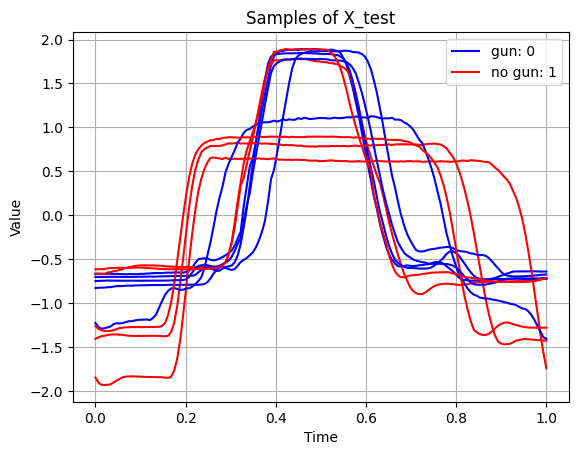

In [13]:
time=np.linspace(0,1,X_test.shape[2])
for i in range(5):
  plt.plot(time,X_test[y_test == [0]][i], 'b-')  # Blue for y=0
  plt.plot(time,X_test[y_test != 0][i], 'r-')

plt.title('Samples of X_test')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend
plt.legend(['gun: 0', 'no gun: 1'])

# Show plot
plt.grid(True)
plt.show()

In [14]:
y_train_ohe_deq = ohe_y(y_train_deq)
y_train_ohe = ohe_y(y_train)
y_test_ohe = ohe_y(y_test)
# print(y_train_ohe)
# print(y_train.squeeze())

In [15]:
batch_size = 32

train_dataloader = create_dataset_and_loader(X_train, y_train_ohe, batch_size)
test_dataloader = create_dataset_and_loader(X_test, y_test_ohe, batch_size)
train_dataloader_deq= create_dataset_and_loader(X_train_deq, y_train_ohe_deq, batch_size)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


## Transfo image

In [16]:
X_train_normalized = normalize(X_train_squeeze)
X_train_img = transform_to_img(X_train_normalized)
train_dataloader_img = create_dataset_and_loader_img(X_train_img,y_train_ohe,mlp=True)
staloader_img = create_dataset_and_loader(X_train_img, y_train_ohe, batch_size)

X_train_normalized_deq = normalize(X_train_deq_squeeze)
X_train_img_deq = transform_to_img(X_train_normalized_deq)
train_dataloader_img_deq = create_dataset_and_loader_img(X_train_img_deq,y_train_ohe_deq,mlp=True)

X_test_normalized = normalize(X_test_squeeze)
X_test_img = transform_to_img(X_test_normalized)
test_dataloader_img = create_dataset_and_loader_img(X_test_img,y_test_ohe,mlp=True)



(88, 150, 150)


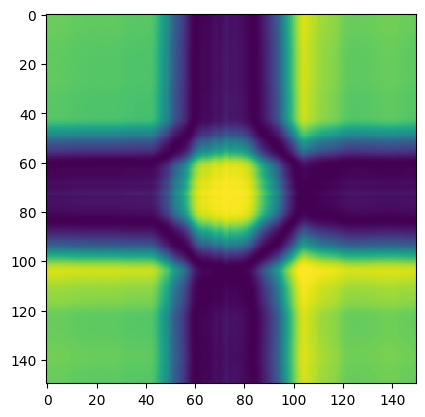

In [17]:
print(X_train_img_deq.shape)
plt.imshow(X_train_img[4])

## Reequilibrage image

In [18]:
PATH = "/content/drive/MyDrive/IA321/data"
images_gen = np.load(PATH + "/CGAN/gen_images.npy")
label_gen = np.load(PATH + "/CGAN/gen_labels.npy")

In [19]:
images_gen.shape

(200, 150, 150)

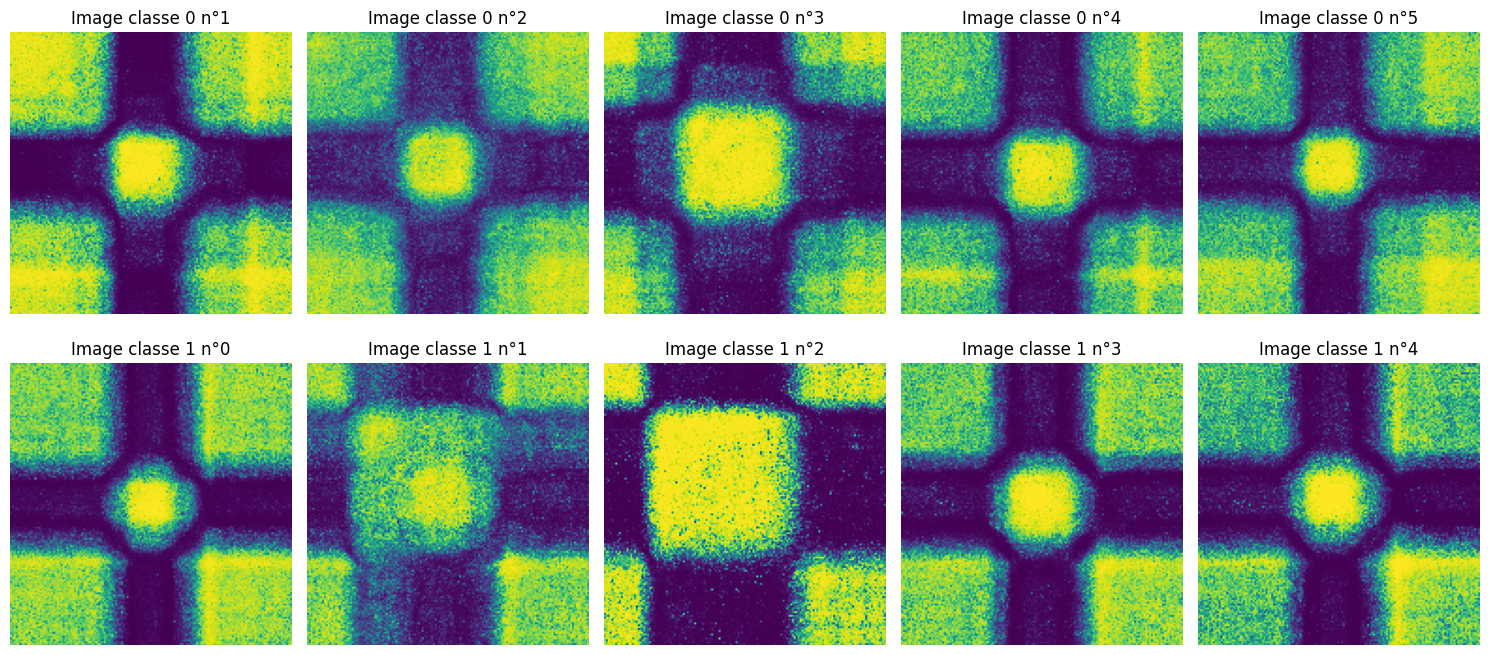

In [20]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

# Plot images on the top row
for i in range(5):
    axes[0, i].imshow(images_gen[i])
    axes[0, i].axis('off')  # Turn off axis labels
    axes[0, i].set_title(f"Image classe 0 n°{i+1}")

# Plot images on the bottom row
for i in range(5):
    axes[1, i].imshow(images_gen[i+100])
    axes[1, i].axis('off')  # Turn off axis labels
    axes[1, i].set_title(f"Image classe 1 n°{i}")




# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
labels_gen_0 = label_gen[:100]
labels_gen_1 = label_gen[100:]
images_gen_0 = images_gen[:100]
images_gen_1 = images_gen[100:]


print("labels 0 (gun):",labels_gen_0[:5])
print("labels 1 (no gun):",labels_gen_1[:5])



labels 0 (gun): [[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
labels 1 (no gun): [[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


In [22]:
print(X_train_deq.shape)
print(y_train_deq.shape)
print(y_train_ohe_deq)
count = np.sum(np.all(y_train_ohe_deq == [0, 1], axis=0))
print([l == [0, 1] for l in y_train_ohe_deq])
sum = np.sum(np.array([l == [0, 1] for l in y_train_ohe_deq]))
print("Number of elements equal to [0, 1]:", sum)

(88, 1, 150)
(88, 1)
[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1]]
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, T

La classe desequilibré est [1,0]

il faut donc utiliser labels_gen_0





In [23]:
print(X_train_img_deq.shape)
print(images_gen_0.shape)

(88, 150, 150)
(100, 150, 150)


In [24]:
X_train_req = np.concatenate([X_train_img_deq,images_gen_0[:72]])
y_train_req = np.concatenate([y_train_ohe_deq,labels_gen_0[:72]])
print(X_train_req.shape)
print(y_train_req.shape)
train_dataloader_img_req_CGAN = create_dataset_and_loader_img(X_train_req,y_train_req,mlp=True)


(160, 150, 150)
(160, 2)


In [25]:
PATH = "/content/drive/MyDrive/IA321/data"
images_gen = np.load(PATH + "/CGAN_VQVAE/gen_images.npy")
label_gen = np.load(PATH + "/CGAN_VQVAE/gen_labels.npy")

In [26]:
images_gen.shape

(200, 1, 150, 150)

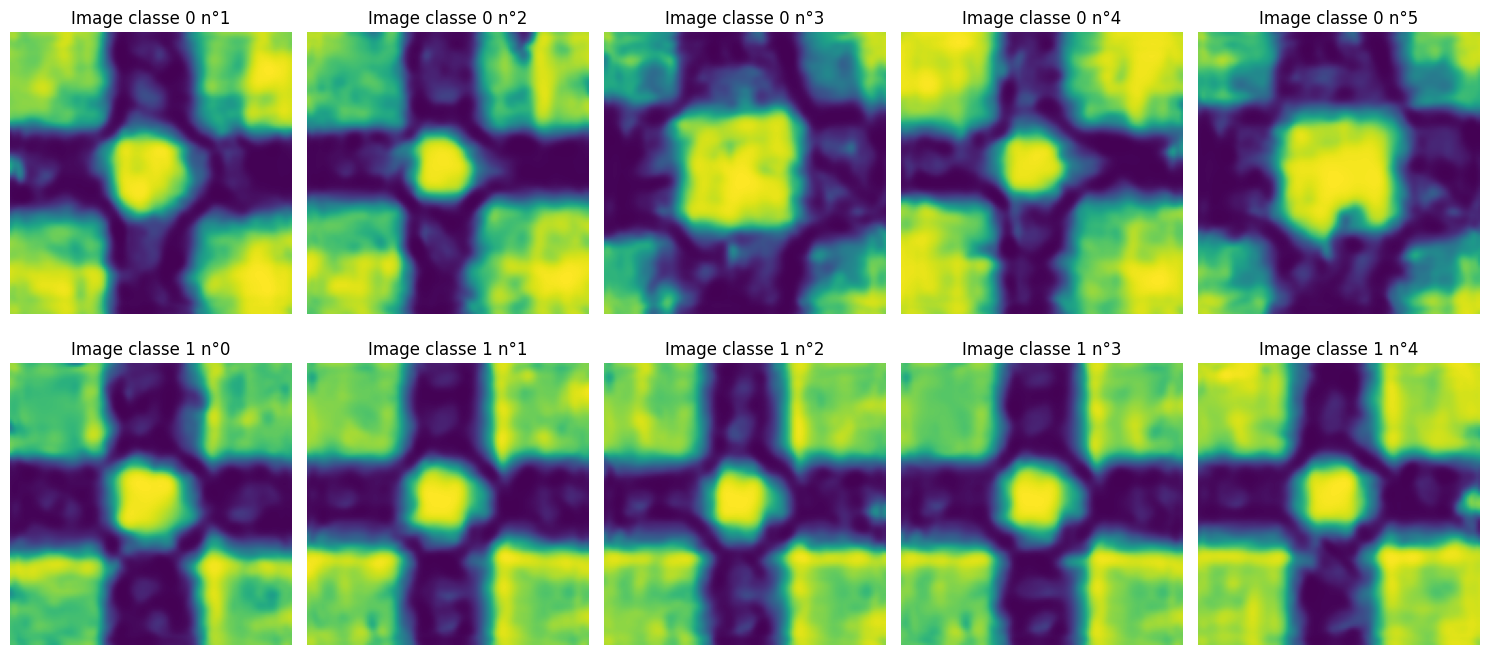

In [27]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

# Plot images on the top row
for i in range(5):
    axes[0, i].imshow(images_gen[i][0])
    axes[0, i].axis('off')  # Turn off axis labels
    axes[0, i].set_title(f"Image classe 0 n°{i+1}")

# Plot images on the bottom row
for i in range(5):
    axes[1, i].imshow(images_gen[i+100][0])
    axes[1, i].axis('off')  # Turn off axis labels
    axes[1, i].set_title(f"Image classe 1 n°{i}")


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [28]:
labels_gen_0 = label_gen[:100]
labels_gen_1 = label_gen[100:]
images_gen_0 = images_gen[:100]
images_gen_1 = images_gen[100:]


print("labels 0 (gun):",labels_gen_0[:5])
print("labels 1 (no gun):",labels_gen_1[:5])

labels 0 (gun): [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
labels 1 (no gun): [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [29]:
images_gen_0 = images_gen_0.squeeze()
X_train_req = np.concatenate([X_train_img_deq,images_gen_0[:72]])
y_train_req = np.concatenate([y_train_ohe_deq,labels_gen_0[:72]])
print(X_train_req.shape)
print(y_train_req.shape)
train_dataloader_img_req_CGAN_VQVAE = create_dataset_and_loader_img(X_train_req,y_train_req,mlp=True)


(160, 150, 150)
(160, 2)


# modèle 1: MLP

In [30]:
class MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels,num_classes):
        super(MLP, self).__init__()
        layers = []
        prev_channel = in_channels
        for hidden_channel in hidden_channels:
            layers.append(nn.Linear(prev_channel, hidden_channel))
            layers.append(nn.ReLU())
            prev_channel = hidden_channel

        layers.append(nn.Linear(prev_channel, num_classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return F.softmax(self.model(x), dim=2).squeeze()





## Initial dataset

Epoch [50/50], Loss: 13.9932: 100%|██████████| 50/50 [00:00<00:00, 75.95it/s]


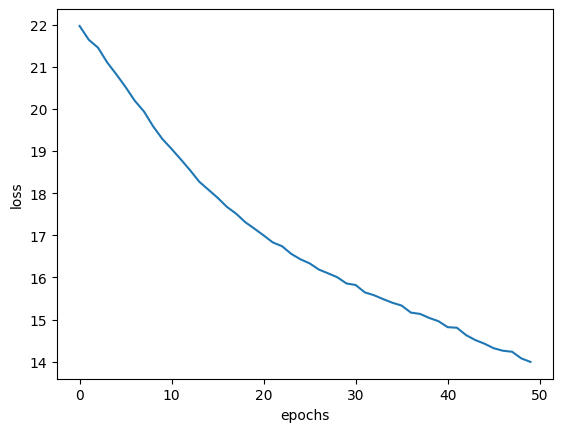

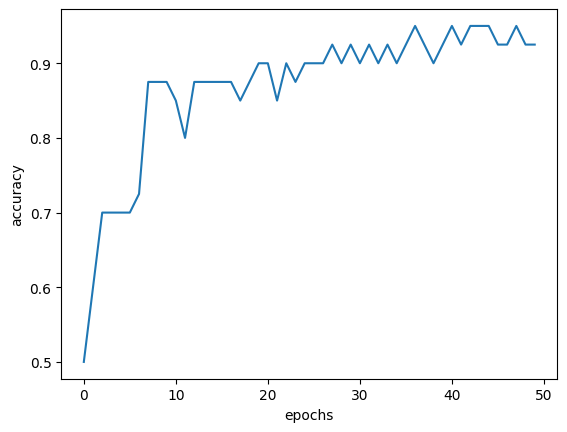

accuracy: 0.925


In [35]:
lr=0.001
in_channels = X_train.shape[2]
hidden_channels = [16]
num_classes = 2
class_weights = torch.tensor([1,1]).to(device)

num_epochs = 50
trainloader = train_dataloader
testloader = test_dataloader

mlp = MLP(in_channels=in_channels, hidden_channels=hidden_channels, num_classes=num_classes)
mlp.to(device)
optimizer= optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(class_weights)


accuracies,losses = train(mlp,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)

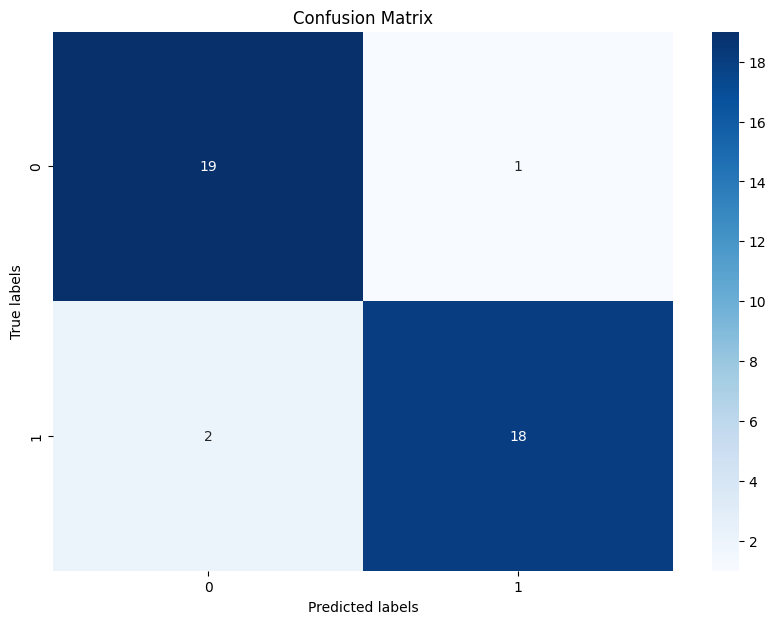

Accuracy by class:
Class 0: 95.00%
Class 1: 90.00%


In [37]:
evaluate_model(mlp, testloader, device)

## time serie desiquilibré


Epoch [100/100], Loss: 1.9170: 100%|██████████| 100/100 [00:01<00:00, 51.69it/s]


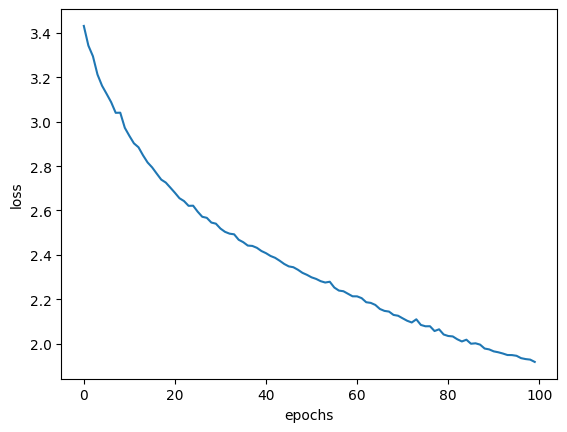

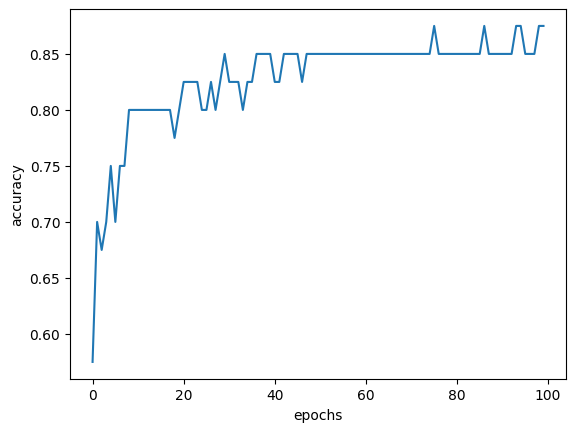

accuracy: 0.875


In [42]:
lr=0.001
in_channels = X_train.shape[2]
hidden_channels = [32]
num_classes = 2
class_weights = torch.tensor([0.9,0.1]).to(device)

num_epochs = 100
trainloader = train_dataloader_deq
testloader = test_dataloader

mlp = MLP(in_channels=in_channels, hidden_channels=hidden_channels, num_classes=num_classes)
mlp.to(device)
optimizer= optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(class_weights)


accuracies, losses = train(mlp,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)

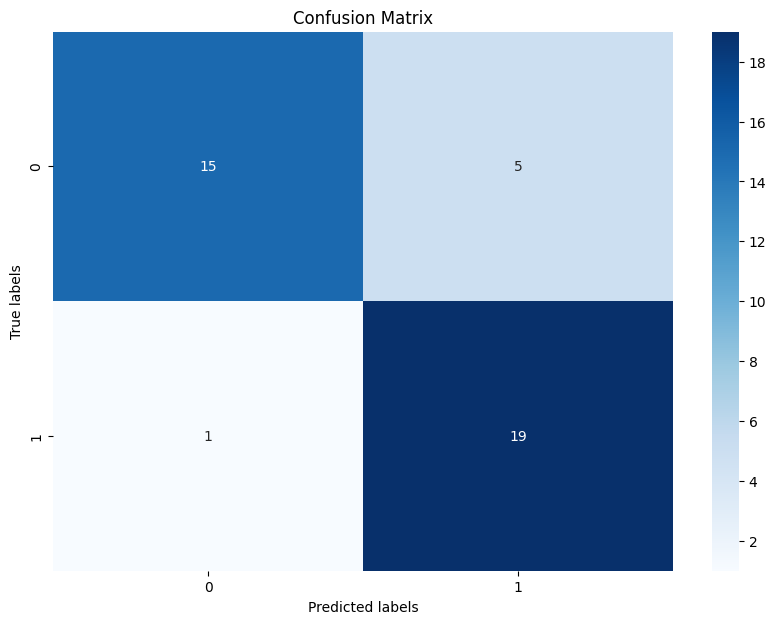

Accuracy by class:
Class 0: 75.00%
Class 1: 95.00%


In [41]:
evaluate_model(mlp, testloader, device)

## image

Epoch [50/50], Loss: 11.9896: 100%|██████████| 50/50 [00:01<00:00, 31.06it/s]


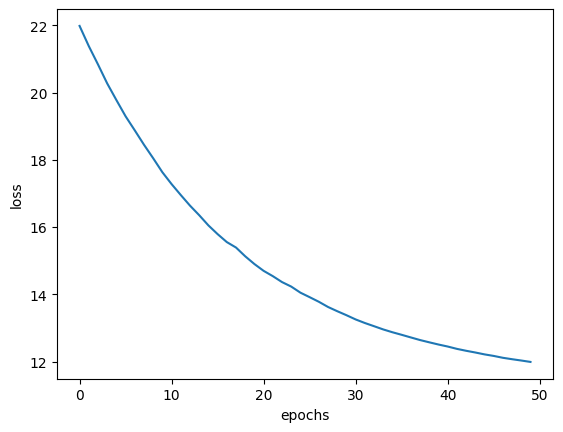

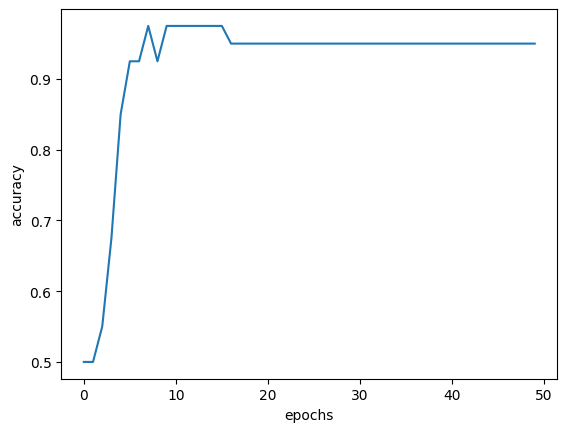

accuracy: 0.95
max accuracy: 0.975


In [43]:
lr=0.00001
in_channels = X_train_img.shape[2]**2
hidden_channels = [64,32]
num_classes = 2

num_epochs = 50
trainloader = train_dataloader_img
testloader = test_dataloader_img
mlp = MLP(in_channels=in_channels, hidden_channels=hidden_channels, num_classes=num_classes)
mlp.to(device)
optimizer= optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


accuracies, losses = train(mlp,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)
print("max accuracy:", np.max(accuracies))

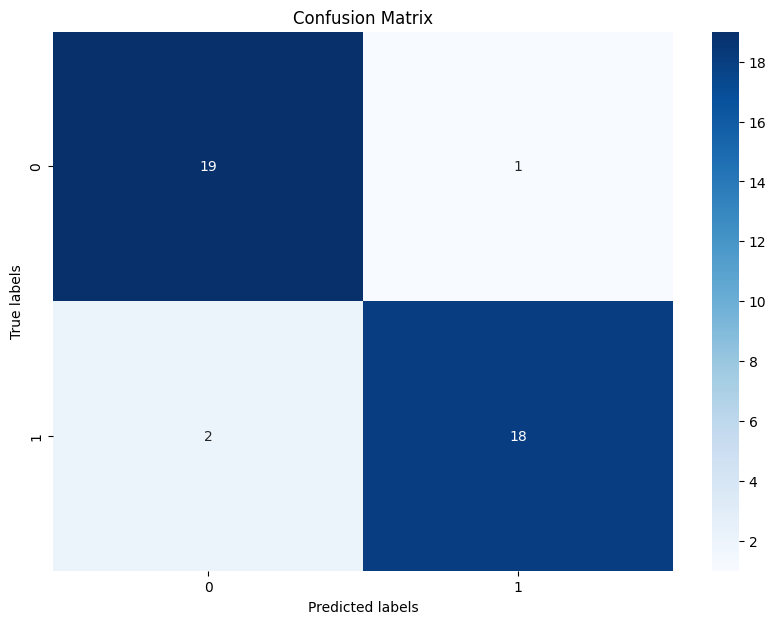

Accuracy by class:
Class 0: 95.00%
Class 1: 90.00%


In [44]:
evaluate_model(mlp, testloader, device)

## image desiquilibrés

Epoch [50/50], Loss: 2.1223: 100%|██████████| 50/50 [00:00<00:00, 62.81it/s]


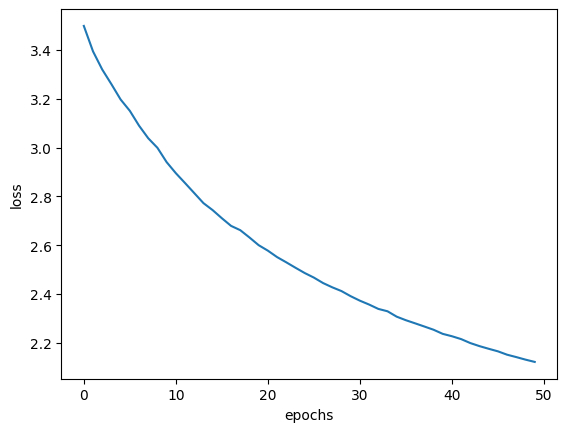

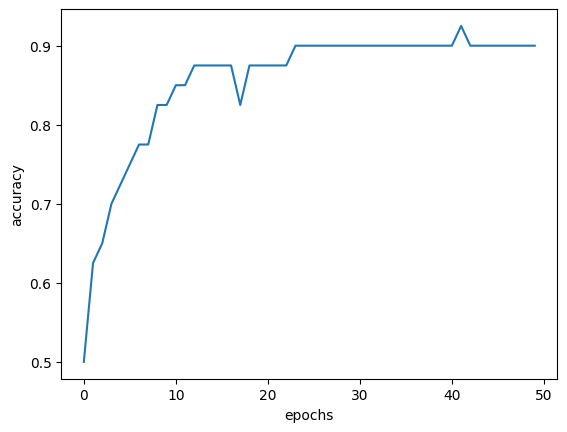

accuracy: 0.9


In [44]:
lr=0.00001
in_channels = X_train_img.shape[2]**2
hidden_channels = [64,32]
num_classes = 2
class_weights = torch.tensor([0.9,0.1]).to(device)


num_epochs = 50
trainloader = train_dataloader_img_deq
testloader = test_dataloader_img
mlp = MLP(in_channels=in_channels, hidden_channels=hidden_channels, num_classes=num_classes)
mlp.to(device)
optimizer= optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(class_weights)


accuracies, losses = train(mlp,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)

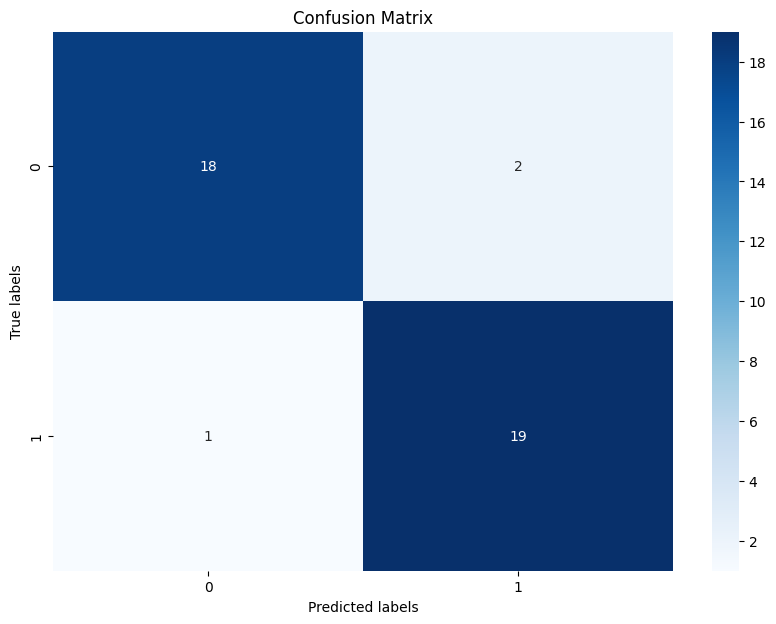

Accuracy by class:
Class 0: 90.00%
Class 1: 95.00%


In [48]:
evaluate_model(mlp, testloader, device)

## image rééquilibrées

Avec CGAN

Epoch [50/50], Loss: 11.0120: 100%|██████████| 50/50 [00:01<00:00, 35.81it/s]


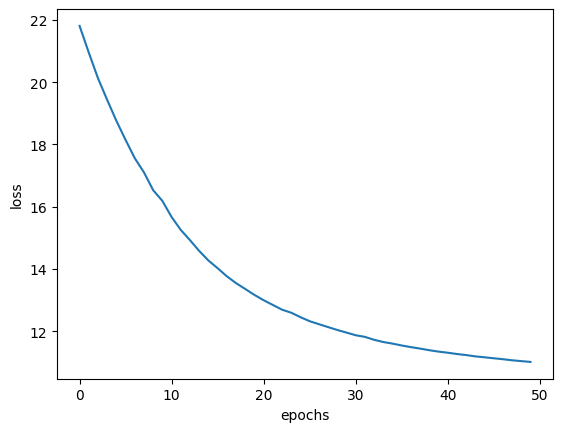

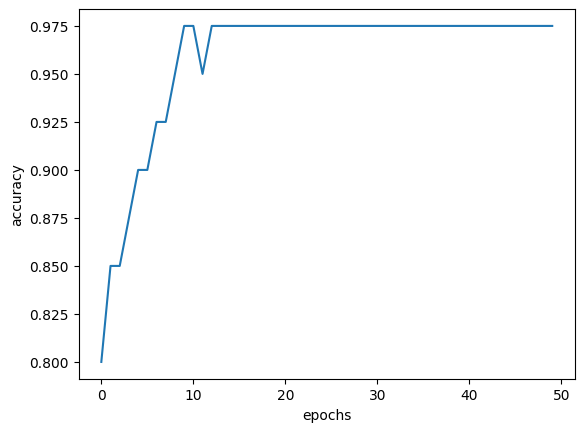

accuracy: 0.975


In [45]:
lr=0.00001
in_channels = X_train_img.shape[2]**2
hidden_channels = [64,32]
num_classes = 2
class_weights = torch.tensor([0.9,0.1]).to(device)


num_epochs = 50
trainloader = train_dataloader_img_req_CGAN
testloader = test_dataloader_img
mlp = MLP(in_channels=in_channels, hidden_channels=hidden_channels, num_classes=num_classes)
mlp.to(device)
optimizer= optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


accuracies, losses = train(mlp,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)


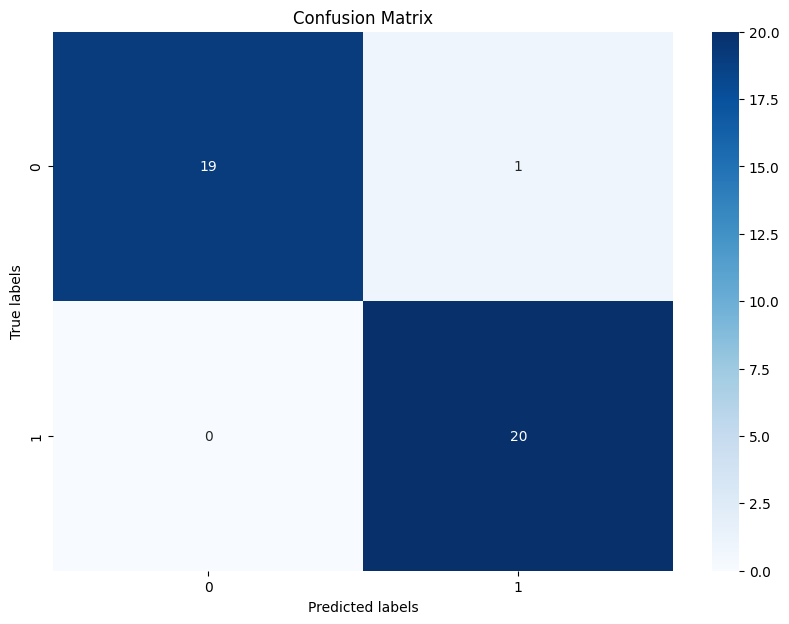

Accuracy by class:
Class 0: 95.00%
Class 1: 100.00%


In [53]:
evaluate_model(mlp, testloader, device)

Avec CGAN/VQ_VAE

Epoch [50/50], Loss: 11.8320: 100%|██████████| 50/50 [00:01<00:00, 31.66it/s]


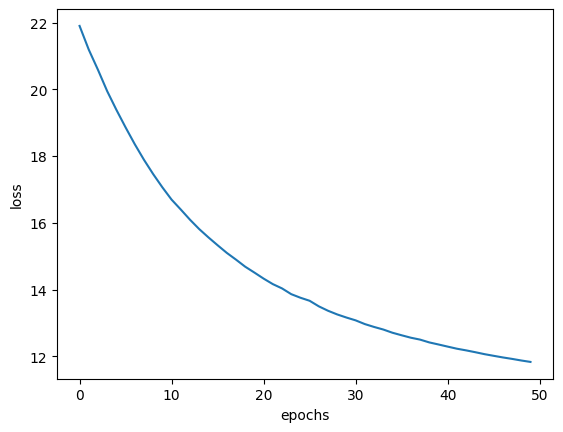

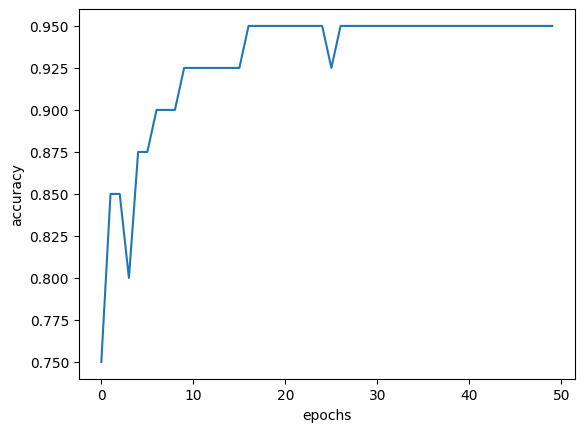

accuracy: 0.95


In [46]:
lr=0.00001
in_channels = X_train_img.shape[2]**2
hidden_channels = [64,32]
num_classes = 2
class_weights = torch.tensor([0.9,0.1]).to(device)


num_epochs = 50
trainloader = train_dataloader_img_req_CGAN_VQVAE
testloader = test_dataloader_img
mlp = MLP(in_channels=in_channels, hidden_channels=hidden_channels, num_classes=num_classes)
mlp.to(device)
optimizer= optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


accuracies, losses = train(mlp,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)


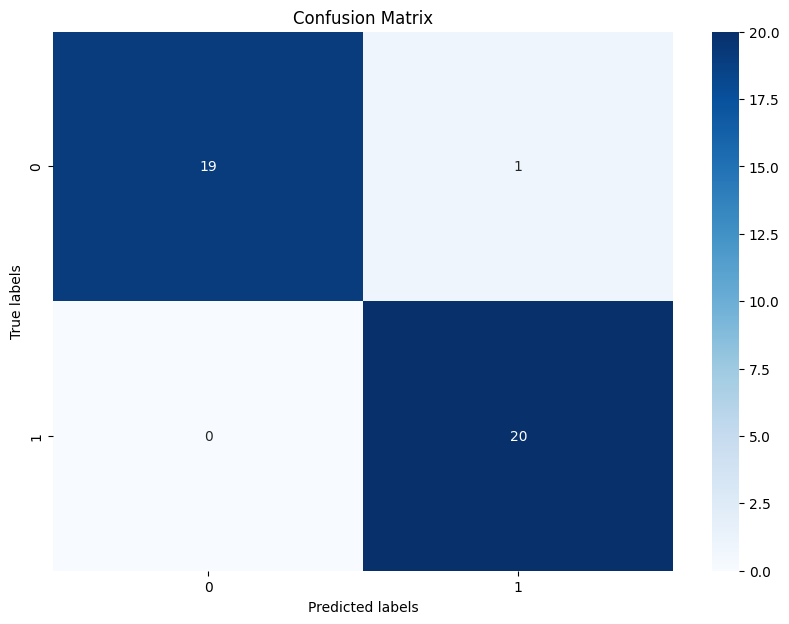

Accuracy by class:
Class 0: 95.00%
Class 1: 100.00%


In [87]:
evaluate_model(mlp, testloader, device)

# modèle 3 : GPT


## modèle

In [48]:
"""
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

logger = logging.getLogger(__name__)

class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, input_size, block_size, num_classes, **kwargs):
        self.input_size = input_size
        self.block_size = block_size
        self.num_classes = num_classes
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 4#12
    n_head = 4#12
    n_embd = 64 #768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.linear = nn.Linear(config.input_size, config.block_size * config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.num_classes, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)

        # logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, x, targets=None):
        x = x.squeeze()
        b, t = x.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        x = self.linear(x) # each index maps to a (learnable) vector
        position_embeddings = self.pos_emb[:, :, :] # each position maps to a (learnable) vector
        x = x.view(-1, config.block_size, config.n_embd)
        # print(x.size())
        # print(position_embeddings.size())
        x = self.drop(x + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        pooled_x = x.mean(dim=1)
        # print("x size before head:",pooled_x.shape)
        logits = self.head(pooled_x)
        logits = F.softmax(logits, dim=-1)
        # print("x size after head:",logits.shape)
        # if we are given some desired targets also calculate the loss
        # loss = None
        # if targets is not None:
        #     loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits

## Initial Dataset

Epoch [100/100], Loss: 10.5202: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


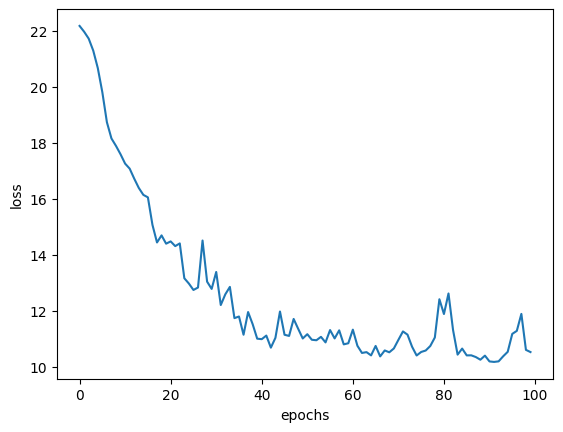

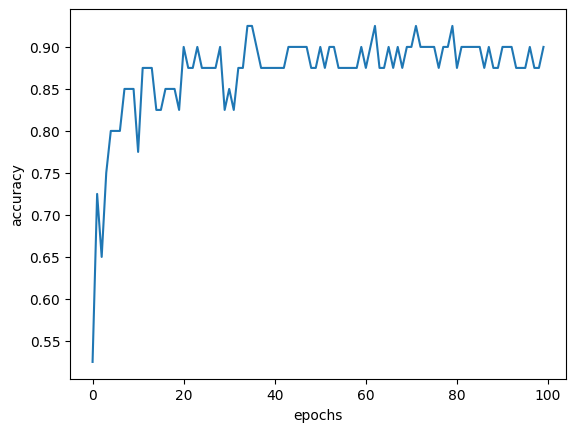

accuracy: 0.9


In [49]:
lr=0.0001
input_size = X_train.shape[2]
num_classes = 2
class_weights = torch.tensor([1,1]).to(device)
block_size = 256



num_epochs = 100
trainloader = train_dataloader
testloader = test_dataloader

config = GPT1Config(input_size,block_size,num_classes)
timeGpt = GPT(config)

timeGpt.to(device)
optimizer= optim.Adam(timeGpt.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(class_weights)


accuracies,losses = train(timeGpt,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)

## time serie desiquilibre

Epoch [100/100], Loss: 2.6788: 100%|██████████| 100/100 [00:10<00:00,  9.60it/s]


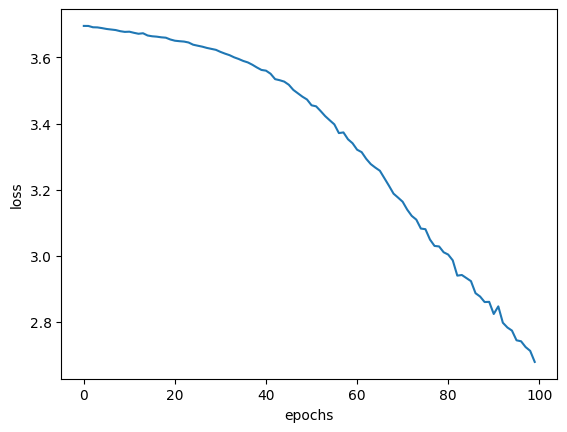

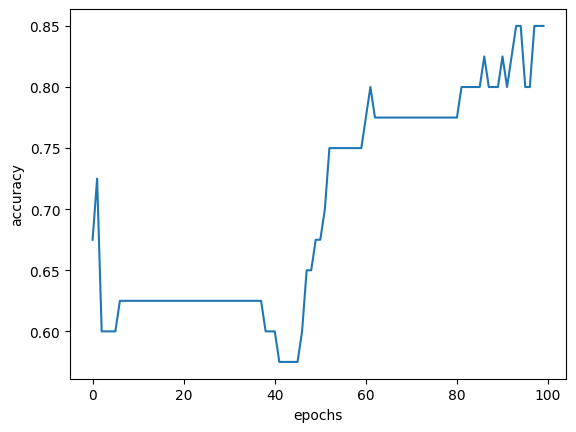

accuracy: 0.85


In [50]:
lr=0.00001
input_size = X_train.shape[2]
num_classes = 2
class_weights = torch.tensor([1,0.1]).to(device)
block_size = 256



num_epochs = 100
trainloader = train_dataloader_deq
testloader = test_dataloader

config = GPT1Config(input_size,block_size,num_classes)
timeGpt = GPT(config)

timeGpt.to(device)
optimizer= optim.Adam(timeGpt.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(class_weights)


accuracies,losses = train(timeGpt,num_epochs,criterion,trainloader,testloader,optimizer)
plot_results(accuracies,losses)